In [19]:
from typing import TypedDict
from typing_extensions import Annotated
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

In [20]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate


In [6]:
llm=ChatGroq(model="openai/gpt-oss-20b",api_key=os.getenv("GROQ_API_KEY"))

In [7]:
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000024594854440>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000024594855160>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
from langchain_tavily import TavilySearch
tool=TavilySearch(max_results=2)

In [9]:
tools=[tool]

In [10]:
llm_with_tools = llm.bind_tools(tools)

In [11]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition



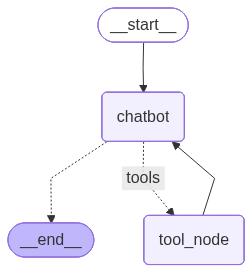

In [21]:
def tool_calling_llm(state: State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}


graph_builder=StateGraph(State)

graph_builder.add_node("chatbot",tool_calling_llm)
graph_builder.add_node("tool_node",ToolNode(tools))

graph_builder.add_edge(START,"chatbot")
graph_builder.add_conditional_edges(
    "chatbot",tools_condition,
    {
        "tools":"tool_node",
        "__end__":END
    }
)
graph_builder.add_edge("tool_node","chatbot")
graph=graph_builder.compile(checkpointer=memory)
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
config={"configurable":{"thread_id":"1"}}

In [29]:
response=graph.invoke({"messages":"Hi,My name is Bhoomika"},config=config)
print(response["messages"][-1].content)

Nice to meet you, Bhoomika! How can I assist you today?


In [31]:
response=graph.invoke({"messages":"what is my name?"},config=config)
print(response["messages"][-1].content)

Your name is **Bhoomika**.


In [33]:
response=graph.invoke({"messages":"what is meant by python?"},config=config)
print(response["messages"][-1].content)

**Python** is a high‑level, general‑purpose programming language known for its readability, simplicity, and versatility.  
It was created by Guido van Rossum and released in 1991, and since then it has become one of the most popular languages for:

- **Web development** (Django, Flask)
- **Data science & machine learning** (pandas, NumPy, scikit‑learn, TensorFlow, PyTorch)
- **Automation & scripting**
- **Desktop applications** (Tkinter, PyQt)
- **Game development** (Pygame)
- **Scientific computing** and more

Key characteristics:

| Feature | What it means |
|---------|---------------|
| **Readable syntax** | Uses indentation to delimit blocks, making code look almost like plain English. |
| **Interpreted** | Runs directly from source code via an interpreter; no separate compilation step. |
| **Dynamic typing** | Variable types are inferred at runtime, so you don’t need to declare them. |
| **Extensive standard library** | Built‑in modules for file I/O, networking, regular expression

In [34]:
response=graph.invoke({"messages":"can you repeat?"},config=config)
print(response["messages"][-1].content)

**Python** is a high‑level, general‑purpose programming language that is:

- **Readable** – uses indentation and a clean syntax.
- **Interpreted** – runs directly from source code.
- **Dynamic‑typed** – types are inferred at runtime.
- **Cross‑platform** – works on Windows, macOS, Linux, etc.
- **Extensively supported** – has a large standard library and many third‑party packages.

It’s widely used for web development, data science, automation, desktop apps, games, and more.


In [35]:
response=graph.invoke({"messages":"Not understood"},config=config)
print(response["messages"][-1].content)

**Python** is a computer language that lets you write instructions for a computer to follow.  
Think of it like a recipe:

- **Easy to read** – the words and punctuation are simple, so beginners can learn quickly.
- **Runs straight away** – you type the recipe and the computer follows it without extra steps.
- **Flexible** – you can use it to build websites, analyze data, automate chores, create games, and much more.

So, Python is just a tool that helps you tell a computer what to do, and it’s popular because it’s simple, powerful, and works on almost any computer.


In [ ]:
from fastapi import FastAPI,HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
from dotenv import load_dotenv
import os
load_dotenv()
app=FastAPI(title="Aggentic Support Bot")
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"]
)

class MessageRequest(BaseModel):
        message:str
@app.get("/")
def root():
        return {"message":"Welcome to AgenticAI support"}
@app.post("/chat")
def chat(request:MessageRequest):
        response=graph.invoke({"messages":request.message})
        messages=response["messages"]
        classification=messages[-2].content
        final_response=messages[-1].content
        return {
                "classification":classification,
                "response":final_response
        }
if __name__=="__main__":
        import uvicorn
        uvicorn.run("main:app",host="0.0.0.0",port=8000,reload=True)


INFO:     Will watch for changes in these directories: ['c:\\Users\\Bhoomi Vaishya\\Documents\\Java Practice\\3rd_year\\AgenticAI3\\chatbot']
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [17460] using StatReload


In [ ]:
# graph.py
from typing import Annotated, TypedDict
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

import os

# Import the tool we just made
from agents.tool import search_tool

# 1. Define State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 2. Setup Tool & Model
tools = [search_tool]
llm = ChatGroq(model="llama3-8b-8192", api_key=os.getenv("GROQ_API_KEY"))
llm_with_tools = llm.bind_tools(tools)

# 3. System Prompt
sys_msg = SystemMessage(content="""
You are a helpful assistant. 
- If the user asks a factual question, use the search tool. 
- If the user chats casually, reply naturally.
""")

# 4. Define Nodes
def assistant(state: State):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# 5. Build Graph
builder = StateGraph(State)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition) # The Decision Maker
builder.add_edge("tools", "assistant")

# Add Memory
memory = MemorySaver()
agent_app = builder.compile(checkpointer=memory)
from IPython.display import Image,display
display(Image(agent_app.get_graph().draw_mermaid_png()))
